# Setup

## Pip install

In [ ]:
# Don't forget to restart runtime after installing

%pip install -U kaleido  --quiet # for saving the still figures
%pip install poppler-utils   # for exporting to .eps extension
%pip install plotly==5.7.0.    # need 5.7.0, not 5.5, so I can use ticklabelstep argument
# %pip freeze
# %pip freeze | grep matplotlib  # get version

     |████████████████████████████████| 79.9 MB 78 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 28.8 MB 1.5 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0


## Base imports


In [1]:
import os
import sys
print(sys.version)
import json
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import skimage
import skimage.io
import requests

import IPython.display
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


In [2]:
colab_ip = %system hostname -I   # uses colab magic to get list from bash
colab_ip = colab_ip[0].strip()   # returns "172.28.0.12"
colab_port = 9000                # could use 6000, 8080, or 9000

notebook_filename = filename = requests.get(f"http://{colab_ip}:{colab_port}/api/sessions").json()[0]["name"]

# Avoids scroll-in-the-scroll in the entire Notebook
def resize_colab_cell():
  display(IPython.display.Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)


#@markdown ### func `def get_path_to_save(...):`
def get_path_to_save(plot_props:dict=None, file_prefix="", save_filename:str=None, save_in_subfolder:str=None, extension="jpg", create_folder_if_necessary=True):
    """
    Code created myself (Rahul Yerrabelli)
    """
    replace_characters = {
        "$": "",
        "\\frac":"",
        "\\mathrm":"",
        "\\left(":"(",
        "\\right)":")",
        "\\left[":"[",
        "\\right]":"]",
        "\\": "",
        "/":"-",
        "{": "(",
        "}": ")",
        "<":"",
        ">":"",
        "?":"",
        "_":"",
        "^":"",
        "*":"",
        "!":"",
        ":":"-",
        "|":"-",
        ".":"_",
    }

    # define save_filename based on plot_props
    if save_filename is None:
        save_filename = "unnamed"

    #save_path = f"../outputs/{notebook_filename.split('.',1)[0]}"
    save_path = [
                 "outputs",
                f"{notebook_filename.split('.',1)[0]}",
                ]
    if save_in_subfolder is not None:
        if isinstance(save_in_subfolder, (list, tuple, set, np.ndarray) ):
            save_path.append(**save_in_subfolder)
        else:  # should be a string then
            save_path.append(save_in_subfolder)
    save_path = os.path.join(*save_path)

    if not os.path.exists(save_path) and create_folder_if_necessary:
        os.makedirs(save_path)
    return os.path.join(save_path, file_prefix+save_filename+"."+extension)
    #plt.savefig(os.path.join(save_path, save_filename+"."+extension))



In [3]:
#@title ## Mount google drive and import my code

mountpoint_folder_name = "drive"  # can be anything, doesn't have to be "drive"
project_path_within_drive = "PythonProjects/SpeculumAnalysis" #@param {type:"string"}
#project_path_within_drive = "UIUC ECs/Rahul_Ashkhan_Projects/SpeculumProjects_Shared/Analysis" #@param {type:"string"}
project_path_full = os.path.join("/content/",mountpoint_folder_name,
                        "MyDrive",project_path_within_drive)

%cd {project_path_full}

<IPython.core.display.Javascript object>

[Errno 2] No such file or directory: '/content/drive/MyDrive/PythonProjects/SpeculumAnalysis'
/content


In [4]:

try:
    import google.colab.drive
    import os, sys
    # Need to move out of google drive directory if going to remount
    %cd
    # drive.mount documentation can be accessed via: drive.mount?
    #Signature: drive.mount(mountpoint, force_remount=False, timeout_ms=120000, use_metadata_server=False)
    google.colab.drive.mount(os.path.join("/content/",mountpoint_folder_name), force_remount=True)  # mounts to a folder called mountpoint_folder_name

    if project_path_full not in sys.path:
        pass
        #sys.path.insert(0,project_path_full)
    %cd {project_path_full}
    
except ModuleNotFoundError:  # in case not run in Google colab
    import traceback
    traceback.print_exc()

<IPython.core.display.Javascript object>

/root
Mounted at /content/drive
/content/drive/MyDrive/Computer Backups/Rahul Yerrabelli drive/PythonProjects/SpeculumAnalysis


# Skip ahead from loaded code

In [5]:
speculum_df_raw = pd.read_pickle("data/02_intermediate/speculum_df_raw"+".pkl")
speculum_df_notfailed = pd.read_pickle("data/02_intermediate/speculum_df_notfailed"+".pkl")

labels_df = pd.read_csv("data/02_intermediate/labels_df.csv", index_col=0)
#with open("data/02_intermediate/label_from_id_dict"+".json", "r") as infile:
#    label_from_id_dict = json.load(infile)
    
df_long = pd.read_pickle(  "data/03_processed/combined_df_long.pkl")
df_wide = pd.read_pickle(  "data/03_processed/combined_df_wide.pkl")
df_wide_flat = pd.read_pickle(  "data/03_processed/combined_df_wide_flat.pkl")

df_agg_long = pd.read_pickle("data/04_aggregated/combined_df_agg_long.pkl")
df_agg_long_flat = pd.read_pickle("data/04_aggregated/combined_df_agg_long_flat.pkl")

df_multiindex = pd.read_pickle("data/03_processed/combined_df_multiindex"+".pkl")


<IPython.core.display.Javascript object>

# Set up for displaying

## Setup dicts and helper functions

In [ ]:
category_orders={"Size": ["S", "M", "L","Unspecified","None"],
                 "Material":["Nitrile","Vinyl","Trojan", "Lifestyle", "Durex", "Skyn","None"],
                 "Material Type":["Glove","Condom","None"],
                 "Method":["Middle","Two","Palm","Middle finger","Two fingers","Palm","Precut","None"],
                 "Speculum Type":["White","Green"]}
labels = {
    "Trial":"Trial #",
    "wd_rel":"Relative Obstruction",
    "wd_rel.mean":"Mean Relative Obstruction (S.E.)", 
    "mmHg":"Pressure (mmHg)", 
    "Material":"Material", "Material Type":"Material Type"
    }


def criteria_to_str(criteria:dict) -> str:
    return ", ".join([f"{labels.get(key) or key}={val}" for key,val in criteria.items()])


def filter_by_criteria(criteria:dict, starting_df:pd.DataFrame) -> pd.DataFrame:
    #df_sampled = df_agg_long_flat.loc[ np.all([df_agg_long[arg]==val for arg, val in criteria.items()], axis=0) ]
    #df_sampled = df_agg_long_flat.loc[ np.all([ (type(val)!=list and df_agg_long[arg]==val ) or np.in1d(df_agg_long[arg],val)  for arg, val in criteria.items()], axis=0) ]
    #starting_df.loc[ np.all([ (type(val)!=list and starting_df[arg]==val ) or np.in1d(starting_df[arg],val)  for arg, val in criteria.items()], axis=0) ]
    conditions = []
    for arg, val in criteria.items():
        if hasattr(val,"__iter__") and not isinstance(val,str):
            conditions.append( np.in1d(starting_df[arg],val) )
        else:
            conditions.append( starting_df[arg]==val )
    return starting_df.loc[ np.all(conditions, axis=0) ]

## Setup  plotly

In [ ]:
default_plotly_save_scale = 4
def save_plotly_figure(fig, file_name:str, animated=False, scale=None, save_in_subfolder:str=None, extensions=None):
    """
    - for saving plotly.express figures only - not for matplotlib
    - fig is of type plotly.graph_objs._figure.Figure,
    - Requires kaleido installation for the static (non-animated) images
    """    
    if scale is None:
        scale = default_plotly_save_scale
    if extensions is None:
        extensions = ["html"]
        if not animated:
            # options = ['png', 'jpg', 'jpeg', 'webp', 'svg', 'pdf', 'eps', 'json']
            extensions += ["eps","png","pdf"]

    for extension in extensions:
        try:
            if extension in ["htm","html"]:
                    fig.write_html( get_path_to_save(save_filename=file_name, save_in_subfolder=save_in_subfolder, extension=extension), 
                        full_html=False,
                        include_plotlyjs="directory" )
            else:
                fig.write_image(get_path_to_save(save_filename=file_name, save_in_subfolder=save_in_subfolder, extension=extension), scale=scale)
        except ValueError as exc:
            import traceback
            #traceback.print_exception()

#col_options = {col_name:pd.unique(df_long[col_name]).tolist() for col_name in consistent_cols}
#display(col_options)

# Stats

## Create SEM tables

In [ ]:

#df_wide.groupby(["Size","Material","Method"]).agg([np.mean, scipy.stats.sem, np.std, np.min, np.median, np.max, np.count_nonzero], ddof=1)
df_agg_wide = df_wide.groupby(["Speculum Type","Material Type","Material","Size","Method","Spec Ang","Spec Ht",]).agg([np.count_nonzero, np.mean, scipy.stats.sem], ddof=1)
df_agg_wide = df_agg_wide.rename(columns={"count_nonzero":"N nonzero"}).sort_index(ascending=False)

df_agg_wide_brief = df_wide.groupby(["Material Type","Material","Size","Method","Spec Ang"]).agg([np.mean, scipy.stats.sem], ddof=1)
df_agg_wide_brief = df_agg_wide_brief.drop(columns=["ht_rel"],level=0).drop(columns=[0],level=1).sort_index(ascending=False, level=[0], sort_remaining=False)
df_agg_wide_brief = df_agg_wide_brief.rename(columns={"Vertical Height":"Opening Height (cm)","wd_rel":"Percent of View Width Obstructed", "sem":"SEM", "mean":"Mean", "Spec Ang":"Clicks", "Material Type":""})
df_agg_wide_brief = df_agg_wide_brief.rename(index={"Unspecified":"","None":""},level=2).rename(index={"Precut":"","None":"","Two":"Two fingers","Middle":"Middle finger"},level=3)

df_agg_wide_brief.columns = df_agg_wide_brief.columns.set_levels([ (f"At {name}mmHg" if type(name)==int else name) for name in df_agg_wide_brief.columns.levels[1]], level=1)
df_agg_wide_brief.columns.names = [None]*len(df_agg_wide_brief.columns.names)
df_agg_wide_brief.index = df_agg_wide_brief.index.rename({"Spec Ang":"Clicks","Material Type":"Type"})
df_agg_wide_brief = df_agg_wide_brief[df_agg_wide_brief.columns.levels[0][::-1]]   # [::-1] reverses the order


# Save
df_agg_wide.to_excel("data/04_aggregated/combined_df_agg_wide.xlsx")
df_agg_wide.to_pickle("data/04_aggregated/combined_df_agg_wide.pkl")

# Save table
styled = df_agg_wide_brief.style
styled = styled.format("{:.2f}",    na_rep="---",  subset=pd.IndexSlice[:,pd.IndexSlice[:,:,"Mean"]])
styled = styled.format("±{:>7.3f}", na_rep="---",  subset=pd.IndexSlice[:,pd.IndexSlice[:,:,"SEM"]])
styled = styled.format("{:.1%}",    na_rep="---",  subset=pd.IndexSlice[:,pd.IndexSlice["Percent of View Width Obstructed",:,"Mean"]])
styled = styled.format("±{:>6.2%}", na_rep="---",  subset=pd.IndexSlice[:,pd.IndexSlice["Percent of View Width Obstructed",:,"SEM"]])
"""styled.set_table_styles({
    ('Opening Height (cm)',"", 'Mean'): [{'selector': 'th', 'props': 'border-left: 1px solid white'},
                               {'selector': 'td', 'props': 'border-left: 1px solid #000066'}]
}, overwrite=False, axis=0)
"""
styled = styled.set_properties(**{"text-align":"right","border-left": "1px solid black","border-bottom":"1px solid black",}, subset=pd.IndexSlice[:,pd.IndexSlice[:,:,"Mean"]])
styled = styled.set_properties(**{"text-align":"left","border-right":"1px solid black","border-bottom":"1px solid black",},  subset=pd.IndexSlice[:,pd.IndexSlice[:,:,"SEM"]])
styled = styled.set_properties(**{"border-left":"2px double black"},  subset=pd.IndexSlice[:,pd.IndexSlice["Opening Height (cm)",:,"Mean"]])
styled.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

#styled = styled.set_caption(f"Varying {varying} with " + criteria_to_str(criteria)).set_table_styles(style_props)
#df_agg_wide_brief.round(3).to_excel("outputs/tables/mean_and_sem_brief.xlsx")

writer = pd.ExcelWriter("outputs/tables/mean_and_sem_brief.xlsx", engine='xlsxwriter')
styled.to_excel(writer,sheet_name="BriefStats")
workbook  = writer.book
worksheet = writer.sheets["BriefStats"]
# Add some cell formats.
format1 = workbook.add_format({'num_format': '#,##0.00'})
format2 = workbook.add_format({'num_format': '0%'})

# Set the format but not the column width.
worksheet.set_column(2, 2, None, format2)
writer.save()


%ls outputs/tables

df_agg_wide_brief.to_excel("data/04_aggregated/combined_df_agg_wide_brief.xlsx", engine='openpyxl')
df_agg_wide_brief.to_pickle("data/04_aggregated/combined_df_agg_wide_brief.pkl")

display(styled)

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


'ANOVA_Varying Material with Material Type=Condom.xlsx'
'ANOVA_Varying Size with Material Type=Glove, Material=Nitrile.xlsx'
 mean_and_sem_brief.xlsx
 mean_and_sem.xlsx


## Test-Retest Reliability, ICC

### Correlations

In [ ]:
#df_long_wd_rel.index.levels[-1]
#df_long_wd_rel = df_long_wd_rel.droplevel("mmHg")
#df_long_wd_rel
df_long_wd_rel = df_long.pivot(index=
                        ["Speculum Type","Material Type","Material","Size","Method","Spec Ang","Spec Ht","mmHg"], 
                        columns="Trial", values=["wd_rel"]) #"ht_rel" #.reset_index("Vertical Height")
df_long_wd_rel.drop(0, level=-1)

<IPython.core.display.Javascript object>

wd_rel  \
Trial                                                                                  1   
Speculum Type Material Type Material  Size        Method Spec Ang Spec Ht mmHg             
White         Condom        Durex     Unspecified Precut 3        0       40    0.577519   
                                                                          80    0.872093   
                                                                          120   0.976744   
                                                                          160   0.988372   
                                                                          200   0.988372   
                            Lifestyle Unspecified Precut 3        0       40    0.599190   
                                                                          80    0.825911   
                                                                          120   0.914980   
                                                                          160   0.971660   
                                                                          200   0.995951   
                            Skyn      Unspecified Precut 3        0       40    0.689076   
                                                                          80    0.890756   
                                                                          120   0.978992   
                                                                          160   0.991597   
                                                                          200   0.987395   
                            Trojan    Unspecified Precut 3        0       40    0.648000   
                                                                          80    0.792000   
                                                                          120   0.900000   
                                                                          160   0.968000   
                                                                          200   0.992000   
              Glove         Nitrile   L           Middle 5        0       40    0.381132   
                                                                          80    0.603774   
                                                                          120   0.735849   
                                                                          160   0.822642   
                                                                          200   0.879245   
                                      M           Middle 5        0       40    0.260700   
                                                                          80    0.533074   
                                                                          120   0.649805   
                                                                          160   0.747082   
                                                                          200   0.828794   
                                                  Two    5        0       40    0.474359   
                                                                          80    0.709402   
                                                                          120   0.854701   
                                                                          160   0.931624   
                                                                          200   0.987179   
                                      S           Middle 5        0       40    0.380137   
                                                                          80    0.592466   
                                                                          120   0.722603   
                                                                          160   0.808219   
                                                                          200   0.869863   
                            Vinyl     M           Middle 3        0       40    0.048860   
                                  

In [ ]:
#df_wide 
#df_wide
df_long_wd_rel = df_long.pivot(index=
                        ["Speculum Type","Material Type","Material","Size","Method","Spec Ang","Spec Ht","mmHg"], 
                        columns="Trial", values=["wd_rel"]) #"ht_rel" #.reset_index("Vertical Height")
df_long_wd_rel = df_long_wd_rel.drop(0, level=-1) # drop 0mmHg because that will always be 0% by definition

df_long_vh = df_long.pivot(index=
                        ["Speculum Type","Material Type","Material","Size","Method","Spec Ang","Spec Ht","mmHg"], 
                        columns="Trial", values=["Vertical Height"]) #"ht_rel" #.reset_index("Vertical Height")
df_long_vh = df_long_vh.drop([40,80,120,160,200], level=-1) # drop 0mmHg because that will always be 0% by definition

#df_long_wd_rel = df_long_wd_rel.dropna(how = 'any')
#display( np.corrcoef( df_long_wd_rel[("wd_rel","1")], df_long_wd_rel[("wd_rel","2")] ) )
#display( df_long_wd_rel[("wd_rel","1")].corr( df_long_wd_rel[("wd_rel","2")] ) )

display( df_long_wd_rel.corr() )
display( df_long_vh.corr() )


<IPython.core.display.Javascript object>

wd_rel                    
Trial                1         2         3
       Trial                              
wd_rel 1      1.000000  0.924046  0.914501
       2      0.924046  1.000000  0.878502
       3      0.914501  0.878502  1.000000

Vertical Height                    
Trial                               1         2         3
                Trial                                    
Vertical Height 1            1.000000  0.979470  0.993943
                2            0.979470  1.000000  0.984493
                3            0.993943  0.984493  1.000000

In [ ]:
df = df_long_wd_rel
df_long_wd_rel_corr = [df.corr().iloc[1,0], df.corr().iloc[2,0], df.corr().iloc[2,1]]
display( np.mean( df_long_wd_rel_corr ) )

df = df_long_vh
df_long_vh_corr = [df.corr().iloc[1,0], df.corr().iloc[2,0], df.corr().iloc[2,1]]
display( np.mean( df_long_vh_corr ) )

<IPython.core.display.Javascript object>

0.9056826811565272

0.9859686245382032

### Library with Heise test-retest calculation

#### Install

In [ ]:
# Package by Lily Eisner. Using v0.0.4. https://github.com/nimh-comppsych/data-reliability-stability/wiki/User-Guide
# Math originally from: Heise, D. R. (1969). Separating reliability and stability in test-retest correlation. American Sociological Review, 34(1), 93–101. https://doi.org/10.2307/2092790
# Other resources: (2015) https://stats.stackexchange.com/questions/152130/how-can-i-quantify-test-retest-reliability-with-three-waves-of-measurement
%pip install reliability-stability-calc==0.0.4

<IPython.core.display.Javascript object>

#### Test

In [ ]:
import reliability_stability as rs

# Pearson's correlation (test-retest reliability for 2 data points)
display( "Correlation", {"wd_rel": rs.calc_correlation(df_long_wd_rel, ("wd_rel","1"), ("wd_rel","2")), 
         "Vertical Height": rs.calc_correlation(df_long_vh, ("Vertical Height","1"), ("Vertical Height","2"))} )
# test retest reliability for 3 datapoints
display( "ICC test retest reliability",{"wd_rel": rs.calc_reliability(df_long_wd_rel, ("wd_rel","1"), ("wd_rel","2"), ("wd_rel","3")),
         "Vertical Height": rs.calc_reliability(df_long_vh, ("Vertical Height","1"), ("Vertical Height","2"), ("Vertical Height","3"))})


<IPython.core.display.Javascript object>

'Correlation'

{'Vertical Height': 0.9794699613431664, 'wd_rel': 0.9240458265915842}

'ICC test retest reliability'

{'Vertical Height': 0.9701580093598774, 'wd_rel': 0.8876711549588678}

#### Display tables

In [ ]:
df = df_long_wd_rel
df_long_wd_rel_corr = [df.corr().iloc[1,0], df.corr().iloc[2,0], df.corr().iloc[2,1]]

df = df_long_vh
df_long_vh_corr = [df.corr().iloc[1,0], df.corr().iloc[2,0], df.corr().iloc[2,1]]

import reliability_stability as rs

df_trt = pd.DataFrame.from_dict( {
    measurement_label: [ 
                  "x".join([str(n) for n in df.shape]), 
                  rs.calc_reliability(df[measurement], "1", "2", "3"), 
                  *df_corr,
                  np.mean(df_corr),
                  ]
    for (measurement_label,measurement), (df,df_corr) in {
        ("Relative Width","wd_rel"):(df_long_wd_rel,df_long_wd_rel_corr), ("Vertical Height","Vertical Height"):(df_long_vh,df_long_vh_corr)
        }.items()
    }, 
    #columns=["N", "Heise", "$R_1,2$", "R1,3", "R2,3", "mean R"],
    columns=["N", "Heise", "R₁₂", "R₁₃", "R₂₃", "mean R"],
    orient="index" )
df_trt

<IPython.core.display.Javascript object>

,N,Heise,R₁₂,R₁₃,R₂₃,mean R
Relative Width,50x3,0.887671,0.924046,0.914501,0.878502,0.905683
Vertical Height,11x3,0.970158,0.979470,0.993943,0.984493,0.985969


In [ ]:
import reliability_stability as rs

df_trt = pd.DataFrame.from_dict( {
    measurement_label: [ 
                  "x".join([str(n) for n in df.shape]), # Display N, but separate out the trial count to "50x3" type format
                  rs.calc_reliability(df[measurement], "1", "2", "3"),  # "1", "2", "3" are the column names
                  df.corr().iloc[1,0], df.corr().iloc[2,0], df.corr().iloc[2,1],
                  np.mean( [df.corr().iloc[1,0], df.corr().iloc[2,0], df.corr().iloc[2,1]] ),
                  ]
    for (measurement_label,measurement), df in {
        ("Vertical Height","Vertical Height"): df_long_vh,
        **{
            ("Relative Width" + (f" at {mmHg}mmHg"  if type(mmHg)==int else " (all)"), "wd_rel"):
             df_long_wd_rel.loc[pd.IndexSlice[:,:,:,:,:,:,:,mmHg]] 
             for mmHg in [pd.IndexSlice[:], 40,80,120,160,200]},  # pd.IndexSlice[:] represents all category;  0 category not included because always the same ("relative")
        }.items()
    }, 
    columns=["N", "Heise", "R₁₂", "R₁₃", "R₂₃", "mean R"],
    orient="index" )
styled = df_trt.style
#styled = styled.set_caption("Heise test-retest reliability and Pearson correlation coefficients comparing the measurements between the three trials of each condition combination")
#styled.to_excel(f"outputs/tables/test_retest_{styled.caption}.xlsx")
styled = styled.set_caption("Heise test-retest reliability")
styled.to_excel(f"outputs/tables/{styled.caption}.xlsx")
df_trt.to_csv(  f"outputs/tables/{styled.caption}.csv", index=True) 
styled

<IPython.core.display.Javascript object>

,N,Heise,R₁₂,R₁₃,R₂₃,mean R
Vertical Height,11x3,0.970158,0.979470,0.993943,0.984493,0.985969
Relative Width (all),50x3,0.887671,0.924046,0.914501,0.878502,0.905683
Relative Width at 40mmHg,10x3,0.863271,0.846103,0.780755,0.796597,0.807819
Relative Width at 80mmHg,10x3,0.911893,0.908187,0.940169,0.944005,0.930787
Relative Width at 120mmHg,10x3,0.868165,0.910171,0.954343,0.910298,0.924937
Relative Width at 160mmHg,10x3,0.837927,0.915694,0.981605,0.898240,0.931847
Relative Width at 200mmHg,10x3,0.878994,0.936233,0.994459,0.933660,0.954784


In [ ]:
df_trt.index

<IPython.core.display.Javascript object>

Index(['Vertical Height', 'Relative Width (all)', 'Relative Width at 40mmHg',
       'Relative Width at 80mmHg', 'Relative Width at 120mmHg',
       'Relative Width at 160mmHg', 'Relative Width at 200mmHg'],
      dtype='object')

### pingouin library

In [ ]:
%pip install pingouin

     |████████████████████████████████| 183 kB 19.8 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 9.8 MB 60.9 MB/s 
  Created wheel for pingouin: filename=pingouin-0.5.1-py3-none-any.whl size=194002 sha256=1d8763ce75d4b3844ea67bac8454e57a6b42ac9a84a6f3112757728256befd42
  Stored in directory: /root/.cache/pip/wheels/74/a7/b6/5b5f03b0395fdada1f45d3aed76e7da48873a02805545ef652
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=9924e3de3f2ff125231b8f1b2a9902324d6d10b2879b429b223a3a0cd9514127
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built pingouin littleutils
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling stats

In [ ]:
import pingouin as pg

icc = pg.intraclass_corr(data=df_long, targets='Set', raters='Trial', ratings='wd_rel')


ImportError: ignored

## ANOVA

### ANOVA Table styling

In [ ]:
#anova_tabless.loc[:,pd.IndexSlice[:,"PR(>F)"]] = anova_tabless.loc[:,pd.IndexSlice[:,"PR(>F)"]].applymap(lambda p: str(p)+''.join(['*' for alpha in [0.001,0.01,0.05] if p<=alpha]))
def apply_anova_table_styling(styled, varying, criteria, anova_types:list=None):
    style_props = [dict(selector="caption",props=[("text-align", "left"),
                   ("font-size", "180%"), ("font-weight","bold"),
                   ]),
               dict(selector='th.col_heading.level0', props=[('font-size','120%;')]),
               dict(selector='th.col_heading', props=[('text-align','center')]) 
               ]
    styled = styled.format(na_rep=" ", precision=4)
    styled = styled.format("{:.0f}",  subset=pd.IndexSlice[:,pd.IndexSlice[:,"df"]])
    styled = styled.applymap(lambda x: f"color: {'red' if x<=0.01 else ('orange' if x<=0.05 else 'black')}",subset=pd.IndexSlice[:,pd.IndexSlice[:,"PR(>F)"]])
    styled = styled.set_caption(f"Varying {varying} with " + criteria_to_str(criteria)).set_table_styles(style_props)
    if anova_types is not None:
        styled = styled.applymap((lambda x: f"opacity: 0.5"),subset=pd.IndexSlice[[f"Type {ind} ANOVA" for ind in range(1,4) if ind not in anova_types],:])
    return styled

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Calculations

In [ ]:
#criteria = [{"Material Type":"Glove","Material":"Nitrile", "mmHg":(ind*40)} for ind in range(6)]
criteria = {"Material Type":"Glove","Material":"Nitrile"}
varying = "Size"

anova_tabless = {}
for ind in range(6):
    criteria_specific = criteria.copy()
    criteria_specific["mmHg"] = ind*40
    #criteria = criterias[ind]
    df_sampled = filter_by_criteria(criteria_specific,df_long)
    
    # Ordinary Least Squares (OLS) model
    model = smf.ols(f"wd_rel ~ C(Q('{varying}'))", data=df_sampled)
    ols_result = model.fit()
    # See article for ANOVA types: https://towardsdatascience.com/anovas-three-types-of-estimating-sums-of-squares-don-t-make-the-wrong-choice-91107c77a27a
    # For type 1, the first argument will be assumed to be the most important
    types = [1,2,3]
    anova_tables = pd.concat(
        [sm.stats.anova_lm(ols_result, typ=type) for type in types],
        axis=1, keys=[f"Type {type} ANOVA" for type in types])
    anova_tabless[f"{criteria_specific['Material Type']} at {criteria_specific['mmHg']}mmHg"] = anova_tables

anova_tabless = pd.concat(anova_tabless,axis=0,keys=[f"{criteria['Material Type']} at {ind*40}mmHg" for ind in range(6)])

styled = anova_tabless.style
apply_anova_table_styling(styled, varying, criteria)
styled = styled.applymap((lambda x: f"opacity: 0.5"),subset=pd.IndexSlice[:,[f"Type {ind} ANOVA" for ind in [2,3]]])
display(styled)
styled.to_excel(f"outputs/tables/ANOVA_{styled.caption}.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1768: RuntimeWarning: invalid value encountered in true_divide
  F /= J
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)


In [ ]:
criteria = {"Material Type":"Condom"}
varying = "Material"

#df_sampled = df_long.loc[ np.all([ (type(val)!=list and df_long[arg]==val ) or np.in1d(df_long[arg],val)  for arg, val in criteria.items()], axis=0) ]
df_sampled = filter_by_criteria(criteria,df_long)
df_sampled.loc[:,"mmHg"] = df_sampled["mmHg"].astype(np.int64)

ys = [("wd","Width (wd)"),("wd_rel","Width % (wd_rel)")]
anova_tabless = {}
types = [1,2,3]
for anova_type in types:
    anova_tables = []
    for ind, (y, y_name) in enumerate(ys):
        # Ordinary Least Squares (OLS) model
        model = smf.ols(f"{y} ~ mmHg + C(Q('{varying}'))", data=df_sampled)
        ols_result = model.fit()
        # See article for ANOVA types: https://towardsdatascience.com/anovas-three-types-of-estimating-sums-of-squares-don-t-make-the-wrong-choice-91107c77a27a
        # For type 1, the first argument will be assumed to be the most important
        
        anova_tables.append( sm.stats.anova_lm(ols_result, typ=anova_type) )
    anova_tabless[f"Type {anova_type} ANOVA"] = pd.concat(anova_tables, axis=1, keys = [y_name for y,y_name in ys]) 

anova_tabless = pd.concat(anova_tabless.values(), axis=0, keys=anova_tabless.keys())

styled = anova_tabless.style
apply_anova_table_styling(styled, varying, criteria, anova_types=[1])
display(styled)
styled.to_excel(f"outputs/tables/ANOVA_{styled.caption}.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
criteria = {"Material Type":"Glove","Material":"Nitrile"}
varying = "Size"

df_sampled = filter_by_criteria(criteria,df_long)
df_sampled.loc[:,"mmHg"] = df_sampled["mmHg"].astype(np.int64)

ys = [("wd","Width (wd)"),("wd_rel","Width % (wd_rel)")]
anova_tabless = {}
types = [1,2,3]
for anova_type in types:
    anova_tables = []
    for ind, (y, y_name) in enumerate(ys):
        # Ordinary Least Squares (OLS) model
        model = smf.ols(f"{y} ~ mmHg + C(Q('{varying}'))", data=df_sampled)
        ols_result = model.fit()
        # See article for ANOVA types: https://towardsdatascience.com/anovas-three-types-of-estimating-sums-of-squares-don-t-make-the-wrong-choice-91107c77a27a
        # For type 1, the first argument will be assumed to be the most important
        
        anova_tables.append( sm.stats.anova_lm(ols_result, typ=anova_type) )
    anova_tabless[f"Type {anova_type} ANOVA"] = pd.concat(anova_tables, axis=1, keys = [y_name for y,y_name in ys]) 

anova_tabless = pd.concat(anova_tabless.values(), axis=0, keys=anova_tabless.keys())

styled = anova_tabless.style
apply_anova_table_styling(styled, varying, criteria, anova_types=[1])
styled = styled.applymap((lambda x: f"opacity: 0.5"),subset=pd.IndexSlice[["Type 2 ANOVA", "Type 3 ANOVA"],:])
display(styled)
#styled.to_excel(f"outputs/tables/ANOVA_{styled.caption}.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
criteria = {"Material Type":["Glove"],"Material":["Nitrile"]}

df_sampled = filter_by_criteria(criteria,df_long)

# Ordinary Least Squares (OLS) model
model = smf.ols("wd_rel ~ mmHg + C(Q('Size'))", data=df_sampled)
ols_result = model.fit()
# See article for ANOVA types: https://towardsdatascience.com/anovas-three-types-of-estimating-sums-of-squares-don-t-make-the-wrong-choice-91107c77a27a
# For type 1, the first argument will be assumed to be the most important
types = [1,2,3]
anova_tables = pd.concat(
    [sm.stats.anova_lm(ols_result, typ=type) for type in types],
    axis=1, keys=[f"ANOVA Type {type}" for type in types])
display(anova_tables)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ANOVA Type 1                                               \
                       df    sum_sq   mean_sq          F        PR(>F)   
mmHg                  5.0  6.185988  1.237198  85.293628  5.876338e-27   
C(Q('Size'))          2.0  0.137872  0.068936   4.752524  1.190172e-02   
Residual             64.0  0.928330  0.014505        NaN           NaN   
Intercept             NaN       NaN       NaN        NaN           NaN   

             ANOVA Type 2                                ANOVA Type 3        \
                   sum_sq    df          F        PR(>F)       sum_sq    df   
mmHg             6.185988   5.0  85.293628  5.876338e-27     6.185988   5.0   
C(Q('Size'))     0.137872   2.0   4.752524  1.190172e-02     0.137872   2.0   
Residual         0.928330  64.0        NaN           NaN     0.928330  64.0   
Intercept             NaN   NaN        NaN           NaN     0.041233   1.0   

                                       
                      F        PR(>F)  
mmHg          85.293628  5.876338e-27  
C(Q('Size'))   4.752524  1.190172e-02  
Residual            NaN           NaN  
Intercept      2.842637  9.666324e-02

## Models

In [ ]:
str(None)

'None'

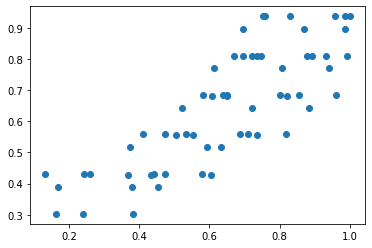

In [ ]:
type(ols_result.predict(df_sampled))
type(df_sampled["wd_rel"])

pd.DataFrame([df_sampled["wd_rel"], ols_result.predict(df_sampled)])

import plotly.express as px
df = px.data.iris()
fig = px.scatter(df, x="sepal_width", y="sepal_length", color="species",
                 size='petal_length', hover_data=['petal_width'])
fig.show()

In [ ]:
ols_result.params

Intercept            0.175930
C(Q('Size'))[T.M]    0.128614
C(Q('Size'))[T.S]    0.087373
mmHg                 0.003165
dtype: float64

In [ ]:
criteria = {"mmHg":[40,80,120,160,200], "Material":["Nitrile"]}
df_sampled = df_long.loc[ np.all([ (type(val)!=list and df_long[arg]==val ) or np.in1d(df_long[arg],val)  for arg, val in criteria.items()], axis=0) ]
#df_sampled.loc[:,"mmHg"] = df_sampled["mmHg"].astype(np.int64)
df_sampled = df_sampled.astype({"mmHg": "int64"})

y = "wd_rel"
varying = "Size"

model = smf.ols(f"{y} ~ mmHg + C(Q('{varying}'))", data=df_sampled)
ols_result = model.fit()
df_sampled["predicted"] = ols_result.predict(df_sampled)

import plotly.express as px
df = px.data.iris()
fig = px.scatter(df_sampled, x="wd_rel", y="predicted", color="Size",
                 size='mmHg', hover_data=['Material'], 
                 #template="simple_white"
                 )
fig.update_layout(shapes = [{'type': 'line', 'yref': 'paper', 'xref': 'paper', 'y0': 0, 'y1': 1, 'x0': 0, 'x1': 1}])

fig.update_layout(
        #shapes = [{'type': 'line', 'yref': 'paper', 'xref': 'paper', 'y0': 0, 'y1': 1, 'x0': 0, 'x1': 1}],
        width=500, height=500,
    )

fig.update_xaxes(tickformat=".0%", tickwidth=2,  nticks=21, ticklabelstep=4,
                        mirror="ticks", linewidth=2, range=(0,1), 
                        showgrid=True, gridcolor="#DDD", 
                        showspikes=True, spikemode="across", spikethickness=2, spikedash="solid", # ticklabelposition="inside top",
                        )
fig.update_yaxes(tickformat=".0%", tickwidth=2,  nticks=21, ticklabelstep=4,
                        mirror="ticks", linewidth=2, range=(0,1), 
                        showgrid=True, gridcolor="#DDD", 
                        showspikes=True, spikemode="across", spikethickness=2, spikedash="solid", # ticklabelposition="inside top",
                        )
fig.show()

In [ ]:
df_sampled

,Order,Set,Speculum Type,Spec Ang,Spec Ht,Size,Material,Material Type,Method,Trial,...,Filename,url,Label ID,wd,ht,wd_start,ht_start,wd_rel,ht_rel,predicted
0,1,1,White,5,0,M,Nitrile,Glove,Middle,1,...,20220423_142023.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2cez4xr5ki20zagcvnuf7sk,257.0,261.0,585.0,2470.0,0.000000,0.000000,210.595238
1,1,1,White,5,0,M,Nitrile,Glove,Middle,1,...,20220423_142031.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2cf020i5j8u0zdfhye4ehjg,190.0,287.0,614.0,2470.0,0.260700,-0.099617,167.857143
2,1,1,White,5,0,M,Nitrile,Glove,Middle,1,...,20220423_142049.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2cf0jjk5jak0zdf8j436nbt,120.0,252.0,655.0,2464.0,0.533074,0.034483,125.119048
3,1,1,White,5,0,M,Nitrile,Glove,Middle,1,...,20220423_142054.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2cf0z834fgl0zbx37jcdzhz,90.0,250.0,670.0,2463.0,0.649805,0.042146,82.380952
4,1,1,White,5,0,M,Nitrile,Glove,Middle,1,...,20220423_142100.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2cez4r95jdf0zam6uu20850,65.0,361.0,672.0,2470.0,0.747082,-0.383142,39.642857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,21,8,White,5,0,M,Nitrile,Glove,Two,3,...,20220423_154934.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2cm8ckq60y10zdfhpbb4q7o,146.0,280.0,930.0,2264.0,0.442748,0.000000,167.857143
86,21,8,White,5,0,M,Nitrile,Glove,Two,3,...,20220423_154939.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2cm8u654x390zbx7a818yqq,82.0,251.0,961.0,2264.0,0.687023,0.103571,125.119048
87,21,8,White,5,0,M,Nitrile,Glove,Two,3,...,20220423_154944.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2cm998q61di0zamh6jlg1ci,52.0,229.0,978.0,2266.0,0.801527,0.182143,82.380952
88,21,8,White,5,0,M,Nitrile,Glove,Two,3,...,20220423_154948.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2cmb2de5z3g0zcafm0xgu2a,28.0,213.0,993.0,2265.0,0.893130,0.239286,39.642857


In [ ]:
df_long.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Order,Speculum Type,Spec Ang,Spec Ht,Size,Material,Material Type,Method,Trial,Vertical Height,mmHg,Filename,url,Label ID,wd,ht,wd_rel,ht_rel
0,1,White,5,0,M,Nitrile,Glove,Middle,1,2.7,0,20220423_142023.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2cez4xr5ki20zagcvnuf7sk,257.0,261.0,0.000000,0.000000
1,1,White,5,0,M,Nitrile,Glove,Middle,1,2.7,40,20220423_142031.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2cf020i5j8u0zdfhye4ehjg,190.0,287.0,0.260700,-0.099617
2,1,White,5,0,M,Nitrile,Glove,Middle,1,2.7,80,20220423_142049.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2cf0jjk5jak0zdf8j436nbt,120.0,252.0,0.533074,0.034483
3,1,White,5,0,M,Nitrile,Glove,Middle,1,2.7,120,20220423_142054.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2cf0z834fgl0zbx37jcdzhz,90.0,250.0,0.649805,0.042146
4,1,White,5,0,M,Nitrile,Glove,Middle,1,2.7,160,20220423_142100.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2cez4r95jdf0zam6uu20850,65.0,361.0,0.747082,-0.383142


In [ ]:
df_long['Material Type']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0      Glove
1      Glove
2      Glove
3      Glove
4      Glove
       ...  
176     None
177     None
178     None
179     None
180     None
Name: Material Type, Length: 181, dtype: object

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                            OLS Regression Results                            
Dep. Variable:                 wd_rel   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     23.91
Date:                Sun, 01 May 2022   Prob (F-statistic):           1.83e-19
Time:                        19:52:19   Log-Likelihood:                 10.218
No. Observations:                 150   AIC:                            -6.436
Df Residuals:                     143   BIC:                             14.64
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

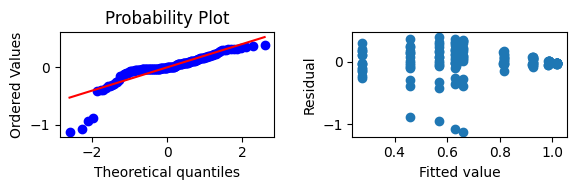

In [ ]:
criteria = {"mmHg":[40,80,120,160,200]}
#varying = "Material"

df_sampled = df_long.loc[ np.all([ (type(val)!=list and df_long[arg]==val ) or np.in1d(df_long[arg],val)  for arg, val in criteria.items()], axis=0) ]

formula = "wd_rel ~ mmHg + C(Q('Material Type')) + C(Material) + C(Size)"
model = smf.ols(formula = formula, data=df_sampled)
ols_result = model.fit()


fig, axs = plt.subplots(1,2, figsize=(6,2), dpi=100)
_ = scipy.stats.probplot(ols_result.resid, plot=axs[0])
#plt.figure()
axs[1].scatter(ols_result.fittedvalues, ols_result.resid)
axs[1].set_xlabel('Fitted value')
axs[1].set_ylabel('Residual')
fig.tight_layout()

print(ols_result.summary())


In [ ]:
df_long

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Order,Speculum Type,Spec Ang,Spec Ht,Size,Material,Material Type,Method,Trial,Vertical Height,mmHg,Filename,url,Label ID,wd,ht,wd_rel,ht_rel
0,1,White,5,0,M,Nitrile,Glove,Middle,1,2.7,0,20220423_142023.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2cez4xr5ki20zagcvnuf7sk,257.0,261.0,0.000000,0.000000
1,1,White,5,0,M,Nitrile,Glove,Middle,1,2.7,40,20220423_142031.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2cf020i5j8u0zdfhye4ehjg,190.0,287.0,0.260700,-0.099617
2,1,White,5,0,M,Nitrile,Glove,Middle,1,2.7,80,20220423_142049.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2cf0jjk5jak0zdf8j436nbt,120.0,252.0,0.533074,0.034483
3,1,White,5,0,M,Nitrile,Glove,Middle,1,2.7,120,20220423_142054.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2cf0z834fgl0zbx37jcdzhz,90.0,250.0,0.649805,0.042146
4,1,White,5,0,M,Nitrile,Glove,Middle,1,2.7,160,20220423_142100.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2cez4r95jdf0zam6uu20850,65.0,361.0,0.747082,-0.383142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,36,White,3,0,None,None,None,None,3,4.1,40,20220423_172235.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2hvx3u007nd107h64biho7u,100.0,392.0,0.615385,-0.015544
177,36,White,3,0,None,None,None,None,3,4.1,80,20220423_172239.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2hvxqgj0a450z8304rfe8au,58.0,364.0,0.776923,0.056995
178,36,White,3,0,None,None,None,None,3,4.1,120,20220423_172242.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2hvy0dw0a1j0zard6uo47jm,30.0,335.0,0.884615,0.132124
179,36,White,3,0,None,None,None,None,3,4.1,160,20220423_172246.jpg,https://storage.labelbox.com/cl2ceiao35hbj0zah...,cl2hvyahh0a7s0z83elgpcx57,19.0,307.0,0.926923,0.204663


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

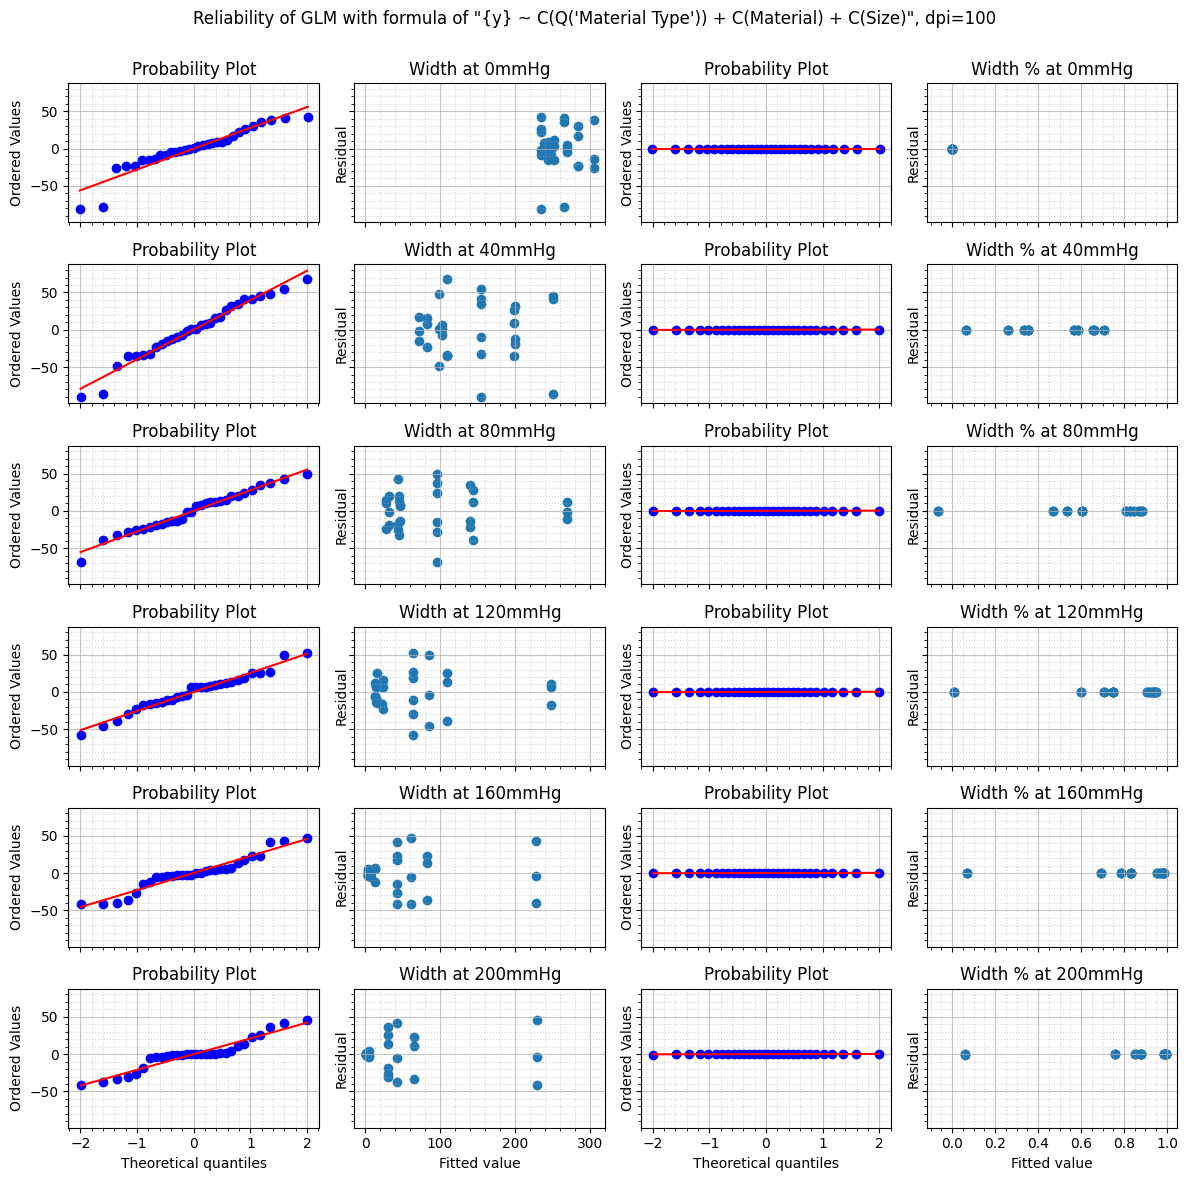

In [ ]:
gen_formula = "{y} ~ C(Q('Material Type')) + C(Material) + C(Size)"
nrows=6
fig, axes = plt.subplots(nrows,4, figsize=(12,2*nrows), dpi=100, sharex="col", sharey="all")
for ind in range(nrows):
    mmHg = 40*ind
    criteria = {"mmHg":[mmHg]}
    df_sampled = df_long.loc[ np.all([ (type(val)!=list and df_long[arg]==val ) or np.in1d(df_long[arg],val)  for arg, val in criteria.items()], axis=0) ]
    
    ys = [("wd","Width"),("wd_rel","Width %")]
    for ind2, (y,y_name) in enumerate(ys):
        #display(df_sampled.head())
        formula = gen_formula.format(y=y)
        model = smf.ols(formula = formula, data=df_sampled)
        ols_result = model.fit()

        _ = scipy.stats.probplot(ols_result.resid, plot=axes[ind,0+ind2*2])
        if ind < nrows-1:
            axes[ind,0+ind2*2].set_xlabel("")

        #plt.figure()
        axes[ind,1+ind2*2].scatter(ols_result.fittedvalues, ols_result.resid)
        axes[ind,1+ind2*2].set_ylabel('Residual')
        axes[ind,1+ind2*2].set_title(f"{y_name} at {mmHg}mmHg")

axes[-1,1].set_xlabel('Fitted value')
axes[-1,3].set_xlabel('Fitted value')

for ind,ax in enumerate(axes.flat):
    ax.grid(which="major", alpha=0.75)  # set major grid lines
    ax.grid(which="minor", alpha=0.5, linestyle=":")  # set minor grid lines, but make them less visible
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

dpi = fig.dpi
title = f"Reliability of GLM with formula of \"{gen_formula}\""+ f", dpi={dpi}".replace("{","").replace("}","")
fig.suptitle(title)
fig.tight_layout(rect=[0,0,1,0.95] )  # rect=[left, bottom, right top]

plt.savefig(get_path_to_save(save_filename=title), 
            bbox_inches='tight')  # Include the bbox_inches='tight' is critical to ensure the saved images aren't cutoff while the colab images are normal


In [ ]:
# Poisson regression code
import statsmodels.api as sm
import statsmodels.formula.api as smf

formula = "Q('Vertical Height') ~ C(Material)"
model = smf.glm(formula = formula, data=df_long, family=sm.families.Binomial())
#model = smf.glm(formula = formula, data=df_wide_flat)
result = model.fit()
print(result.summary())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                  Generalized Linear Model Regression Results                   
Dep. Variable:     Q('Vertical Height')   No. Observations:                  181
Model:                              GLM   Df Residuals:                      174
Model Family:                  Binomial   Df Model:                            6
Link Function:                    logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                    nan
Date:                  Sun, 01 May 2022   Deviance:                          nan
Time:                          19:23:55   Pearson chi2:                 5.35e+18
No. Iterations:                     100                                         
Covariance Type:              nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Inte

/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:942: RuntimeWarning: divide by zero encountered in true_divide
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:942: RuntimeWarning: invalid value encountered in add
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:943: RuntimeWarning: divide by zero encountered in log
  n * np.log(1 - mu)) * var_weights
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/

In [ ]:
exog, endog = sm.add_constant(x), y
mod = sm.GLM(endog, exog,
             family=sm.families.Poisson(link=sm.families.links.log))
res = mod.fit()